In [1]:
import torch
print(torch.__version__)

2.7.1+cu128


In [10]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load ImageNet class names
with open('imagenet_classes.txt') as f:
    class_names = [line.strip() for line in f.readlines()]

# Load pre-trained ResNet152 with correct API
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2050


---

Добавим софтмакс прямо в архтектуру

In [12]:
import torch.nn as nn

# Load pre-trained ResNet152 with correct API
model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

# Add Softmax layer at the end
model = nn.Sequential(
    model,  # Original ResNet152
    nn.Softmax(dim=1)  # Adds Softmax to convert outputs to probabilities
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval();

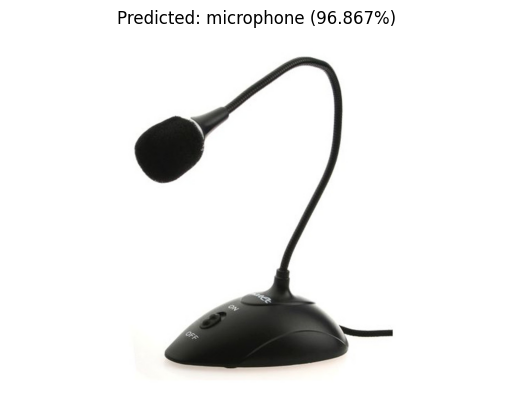

In [13]:
# Загрузите изображение для инференса
image_path = 'test_images/1.jpg'  # Замените на путь к вашему изображению
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device)  # Добавляем размер батча

# Прогоните изображение через модель
with torch.no_grad():
    output = model(image_tensor)

# Примените softmax для получения вероятностей классов
probabilities = output.cpu()

# Отображение результатов
top_prob, top_class = torch.topk(probabilities, 1)
top_prob = top_prob.item()
top_class = top_class.item()

# Получить имя класса
class_name = class_names[top_class]

# Отобразить изображение
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {class_name} ({top_prob*100:.3f}%)')
plt.show()

# ONNX

In [14]:
# Экспорт модели в формат ONNX
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # Пример входного тензора
onnx_file_path = "model.onnx"  # Путь для сохранения ONNX файла

# Экспорт модели
with torch.no_grad():
    torch.onnx.export(
        model,  # Модель PyTorch
        dummy_input,  # Пример входных данных
        onnx_file_path,  # Путь для сохранения ONNX файла
        export_params=True,  # Экспортировать обученные параметры
        opset_version=14,  # Версия ONNX операторов
        do_constant_folding=True,  # Оптимизация констант
        input_names=["input"],  # Имя входного тензора
        output_names=["output"],  # Имя выходного тензора
        dynamic_axes={
            "input": {0: "batch_size"},  # Динамический размер батча
            "output": {0: "batch_size"},
        },
    )

print(f"Модель успешно экспортирована в файл: {onnx_file_path}")  

Модель успешно экспортирована в файл: model.onnx
